In [1]:
import pandas as pd
from scipy import stats
import numpy as np

## import data

[Human resources in science and technology by sex, country](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240613-2).

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

European health interview survey. [Working hours per week](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240530-1).

In [3]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

Purchasing power parities (PPPs), price level indices and real expenditures. [Household consumption, price levels](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240620-2).

In [4]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

Enterprises by detailed NACE Rev.2 activity and special aggregates. [People employed in finance and insurance](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240610-2).

In [5]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [6]:
def process_csv(df):
    return (df
            .query("geo in ('AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI','FR','HR','HU','IE','IT','LT','LU','LV','MT','NL','NO','PL','PT','RO','RS','SE','SI','SK')")
            .set_index('geo')[['OBS_VALUE']]
           )

In [7]:
def normalised(df):
    return (df-df.min())/(df.max()-df.min())


 G7: Canada, France, Germany, Italy, Japan, the United Kingdom and the United States. Of which the relevant to Eurostat data are France, Germany, Italy.

Eastern European countries with mostly geographic definition, including historic NATO member Greece, non aligned former Yugoslavia and Cyprus, but not Finland. Note that modern Germany includes the former German Democratic Republic (East Germany) though overall numbers probably dominated by Berlin and former West Germany.

In [8]:
merged_stats=(lfsa_ewhais
 #.assign(g7=lfsa_ewhais.geo.where(lfsa_ewhais.geo in ('FR','DE','IT')))
 .pipe(process_csv)
 .pipe(normalised)
 .rename(columns={"OBS_VALUE":"weekly_h"})
 .assign(fem_scitech=pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])
         .pipe(normalised),
         financiers=sbs_ovw_act
        .pipe(process_csv)
        .pipe(normalised),
         scientists= hrst_st_rsex
        .query("sex=='T'")
        .pipe(process_csv)
        .pipe(normalised),
         prices=prc_ppp_ind
        .pipe(process_csv)
        .pipe(normalised),
         east_west_g7=pd.Series(data=['W','W','E','E','E','G7','W','E','E','W','W','G7','E','E','W','G7','E','W','E',
                             'W','W','W','E','W','E','E','W','E','E'],
                             index=['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
                             'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'])
        )
             )
        
              #.reset_index()
              #.query('geo!="EU27_2020"')


# visualise data

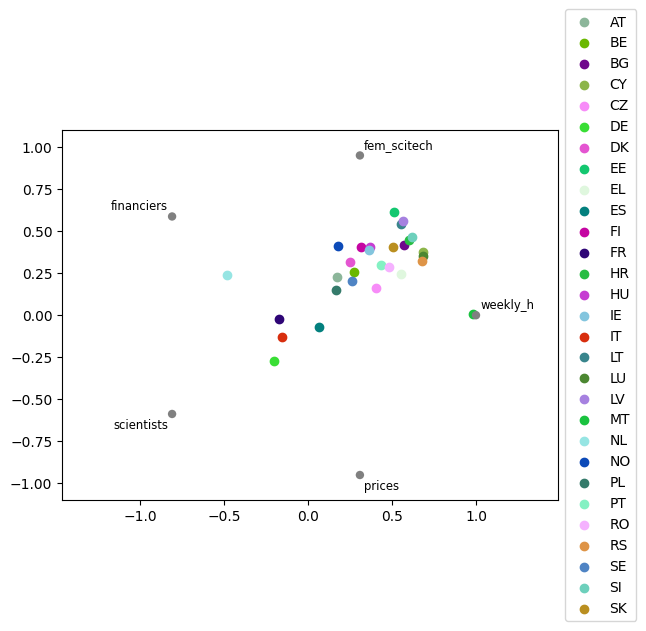

In [9]:
(pd
 .plotting
 .radviz(merged_stats.drop(columns=['east_west_g7']).reset_index(),'geo')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

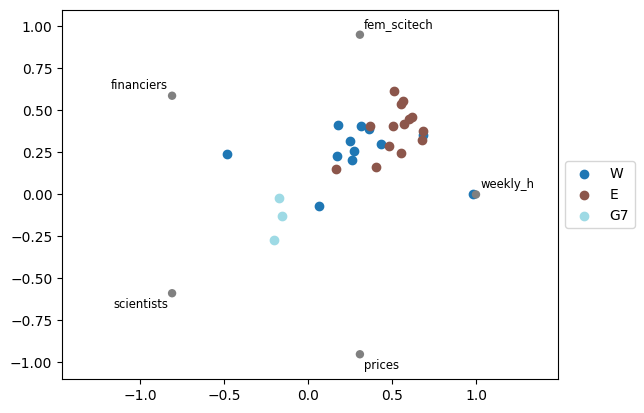

In [10]:
(pd
 .plotting
 .radviz(merged_stats,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
#,colors={'W':'tab_bluew','E':'tab_red'}

parallel coordinates crowded for prices and financiers near 0.0-0.2, this corresponds to the bottom left quadrant of the radviz being empty? And likewise busy top right radviz quadrant correspond to the many lines at 0.2-1.0 for weekly hours and females in science and technology. 

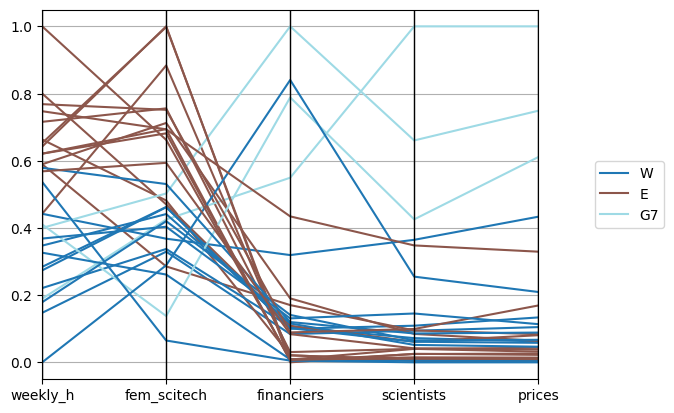

In [11]:
(pd
 .plotting
 .parallel_coordinates(merged_stats,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.1, 0.5))
)

In [12]:
merged_stats.sort_values(['financiers'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
FR,0.400000,0.502564,1.000000,0.660414,0.748723,G7
NL,0.000000,0.288934,0.840365,0.255054,0.209411,W
IT,0.410526,0.137772,0.788511,0.425531,0.610768,G7
DE,0.189474,0.425074,0.549482,1.000000,1.000000,G7
PL,0.747368,0.693510,0.434395,0.347962,0.329360,E
ES,0.442105,0.367998,0.319263,0.364630,0.433347,W


In [13]:
merged_stats.sort_values(['prices'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
DE,0.189474,0.425074,0.549482,1.000000,1.000000,G7
FR,0.400000,0.502564,1.000000,0.660414,0.748723,G7
IT,0.410526,0.137772,0.788511,0.425531,0.610768,G7
ES,0.442105,0.367998,0.319263,0.364630,0.433347,W
PL,0.747368,0.693510,0.434395,0.347962,0.329360,E
NL,0.000000,0.288934,0.840365,0.255054,0.209411,W


In [14]:
merged_stats.sort_values(['scientists'],ascending=False).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
DE,0.189474,0.425074,0.549482,1.000000,1.000000,G7
FR,0.400000,0.502564,1.000000,0.660414,0.748723,G7
IT,0.410526,0.137772,0.788511,0.425531,0.610768,G7
ES,0.442105,0.367998,0.319263,0.364630,0.433347,W
PL,0.747368,0.693510,0.434395,0.347962,0.329360,E
NL,0.000000,0.288934,0.840365,0.255054,0.209411,W


Spain, Poland, and Netherlands comparable to G7 members

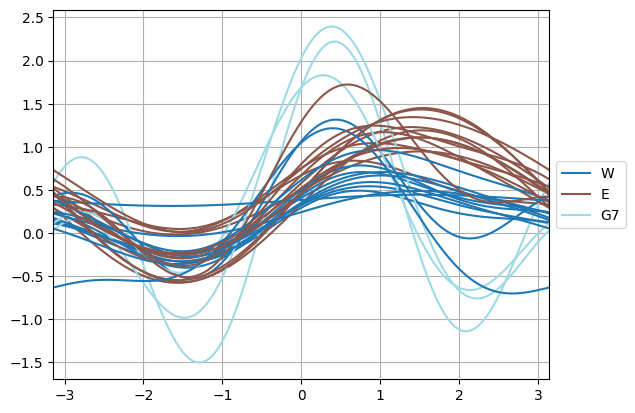

In [15]:
(pd
 .plotting
 .andrews_curves(merged_stats,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

> $ f(t) = \frac{x_1}{\sqrt{2}} + x_2 \sin(t) + x_3 \cos(t) + x_4 \sin(2t) + x_5 \cos(2t) + \cdots $
Where x coefficients correspond to the values of each dimension
and t is linearly spaced between $ -\pi$ and $+\pi$ .
Each row of frame then corresponds to a single curve.

So the first coefficient is the dc component, the next two the in phase and quadrature component of the fundamental, and the next one the in phase component of the first harmonic. 
- The few countries with significant contribution to first harmonic create the trough after 2, which are the same as the ones with high value of people working in finance and insurance.
- Phase differences between the other countries are due to how females in science and technology compares to prices.

array([[<Axes: xlabel='weekly_h', ylabel='weekly_h'>,
        <Axes: xlabel='fem_scitech', ylabel='weekly_h'>,
        <Axes: xlabel='financiers', ylabel='weekly_h'>,
        <Axes: xlabel='scientists', ylabel='weekly_h'>,
        <Axes: xlabel='prices', ylabel='weekly_h'>],
       [<Axes: xlabel='weekly_h', ylabel='fem_scitech'>,
        <Axes: xlabel='fem_scitech', ylabel='fem_scitech'>,
        <Axes: xlabel='financiers', ylabel='fem_scitech'>,
        <Axes: xlabel='scientists', ylabel='fem_scitech'>,
        <Axes: xlabel='prices', ylabel='fem_scitech'>],
       [<Axes: xlabel='weekly_h', ylabel='financiers'>,
        <Axes: xlabel='fem_scitech', ylabel='financiers'>,
        <Axes: xlabel='financiers', ylabel='financiers'>,
        <Axes: xlabel='scientists', ylabel='financiers'>,
        <Axes: xlabel='prices', ylabel='financiers'>],
       [<Axes: xlabel='weekly_h', ylabel='scientists'>,
        <Axes: xlabel='fem_scitech', ylabel='scientists'>,
        <Axes: xlabel='financier

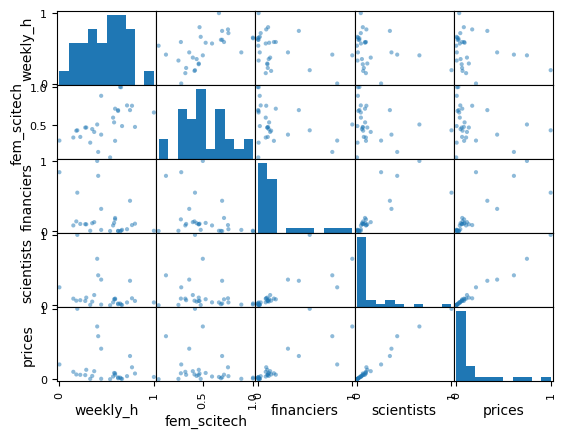

In [16]:
pd.plotting.scatter_matrix(
merged_stats.drop(columns=['east_west_g7'])
)

In [17]:
merged_stats.drop(columns=['east_west_g7']).corr()

,weekly_h,fem_scitech,financiers,scientists,prices
weekly_h,1.000000,0.525280,-0.382036,-0.312867,-0.281540
fem_scitech,0.525280,1.000000,-0.335678,-0.229587,-0.250826
financiers,-0.382036,-0.335678,1.000000,0.786460,0.804731
scientists,-0.312867,-0.229587,0.786460,1.000000,0.985902
prices,-0.281540,-0.250826,0.804731,0.985902,1.000000


# Log transformation for Financiers and Price Index

see [You're probably overthinking it](https://allendowney.github.io/ProbablyOverthinkingIt/intro.html)

In [18]:
def process_log_csv(df):
    return (np
            .log(
                df
                .query("geo in ('AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI','FR','HR','HU','IE','IT','LT','LU','LV','MT','NL','NO','PL','PT','RO','RS','SE','SI','SK')")
                .set_index('geo')[['OBS_VALUE']]
            )
           )

In [19]:
merged_stats_lognorm=(lfsa_ewhais
 #.assign(g7=lfsa_ewhais.geo.where(lfsa_ewhais.geo in ('FR','DE','IT')))
 .pipe(process_csv)
 .pipe(normalised)
 .rename(columns={"OBS_VALUE":"weekly_h"})
 .assign(fem_scitech=pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])
         .pipe(normalised),
         financiers=sbs_ovw_act
        .pipe(process_log_csv)
        .pipe(normalised),
         scientists= hrst_st_rsex
        .query("sex=='T'")
        .pipe(process_log_csv)
        .pipe(normalised),
         prices=prc_ppp_ind
        .pipe(process_log_csv)
        .pipe(normalised),
         east_west_g7=pd.Series(data=['W','W','E','E','E','G7','W','E','E','W','W','G7','E','E','W','G7','E','W','E',
                             'W','W','W','E','W','E','E','W','E','E'],
                             index=['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
                             'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'])
        )
             )
        
              #.reset_index()
              #.query('geo!="EU27_2020"')


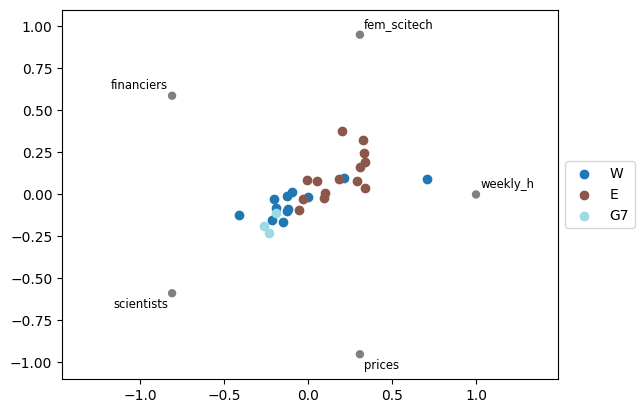

In [20]:
(pd
 .plotting
 .radviz(merged_stats_lognorm,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
#,colors={'W':'tab_bluew','E':'tab_red'}

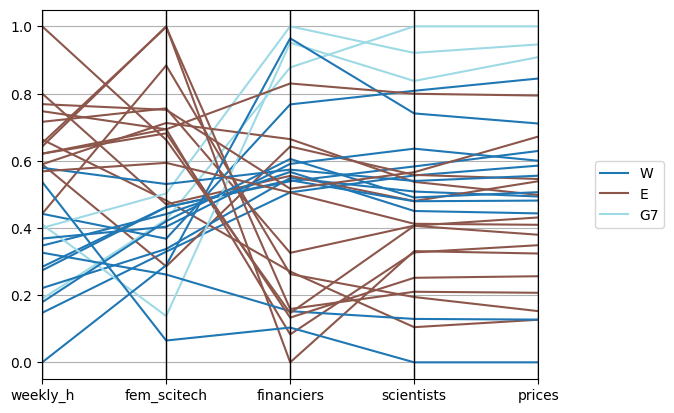

In [21]:
(pd
 .plotting
 .parallel_coordinates(merged_stats_lognorm,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.1, 0.5))
)

In [22]:
merged_stats.sort_values(['prices'],ascending=True).iloc[0:6]

,weekly_h,fem_scitech,financiers,scientists,prices,east_west_g7
geo,,,,,,
MT,0.536842,0.064921,0.005168,0.000000,0.000000,W
CY,0.663158,0.481671,0.021477,0.003980,0.004649,E
LU,0.326316,0.261273,0.008661,0.005271,0.004670,W
EE,0.442105,0.883553,0.020405,0.009623,0.006039,E
LV,0.652632,0.997748,0.009190,0.010909,0.009710,E
SI,0.621053,0.681598,0.007194,0.014872,0.014079,E


Malta and Luxembourg stand out!

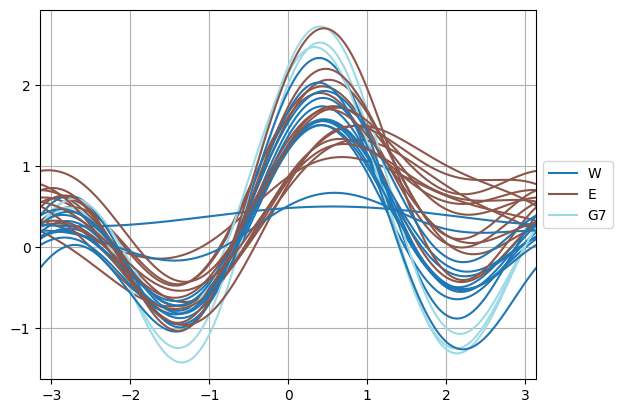

In [23]:
(pd
 .plotting
 .andrews_curves(merged_stats_lognorm,'east_west_g7',colormap='tab20')
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

In [24]:
#import yellowbrick

# Correlations

G7 expensive, and with a lot of people working in finance/insurance. They stand out from the rest and from each other.

Eastern Europe: People work long hours, much higher percentage of women in science and technology. These dimensions form a continuum, most east european countries occupy the top half of the continuum but there is no clear clustering

In [25]:
merged_stats_lognorm.drop(columns=['east_west_g7']).corr()

,weekly_h,fem_scitech,financiers,scientists,prices
weekly_h,1.000000,0.525280,-0.443974,-0.319816,-0.288762
fem_scitech,0.525280,1.000000,-0.418424,-0.221371,-0.229726
financiers,-0.443974,-0.418424,1.000000,0.892595,0.881933
scientists,-0.319816,-0.221371,0.892595,1.000000,0.991712
prices,-0.288762,-0.229726,0.881933,0.991712,1.000000


array([[<Axes: xlabel='weekly_h', ylabel='weekly_h'>,
        <Axes: xlabel='fem_scitech', ylabel='weekly_h'>,
        <Axes: xlabel='financiers', ylabel='weekly_h'>,
        <Axes: xlabel='scientists', ylabel='weekly_h'>,
        <Axes: xlabel='prices', ylabel='weekly_h'>],
       [<Axes: xlabel='weekly_h', ylabel='fem_scitech'>,
        <Axes: xlabel='fem_scitech', ylabel='fem_scitech'>,
        <Axes: xlabel='financiers', ylabel='fem_scitech'>,
        <Axes: xlabel='scientists', ylabel='fem_scitech'>,
        <Axes: xlabel='prices', ylabel='fem_scitech'>],
       [<Axes: xlabel='weekly_h', ylabel='financiers'>,
        <Axes: xlabel='fem_scitech', ylabel='financiers'>,
        <Axes: xlabel='financiers', ylabel='financiers'>,
        <Axes: xlabel='scientists', ylabel='financiers'>,
        <Axes: xlabel='prices', ylabel='financiers'>],
       [<Axes: xlabel='weekly_h', ylabel='scientists'>,
        <Axes: xlabel='fem_scitech', ylabel='scientists'>,
        <Axes: xlabel='financier

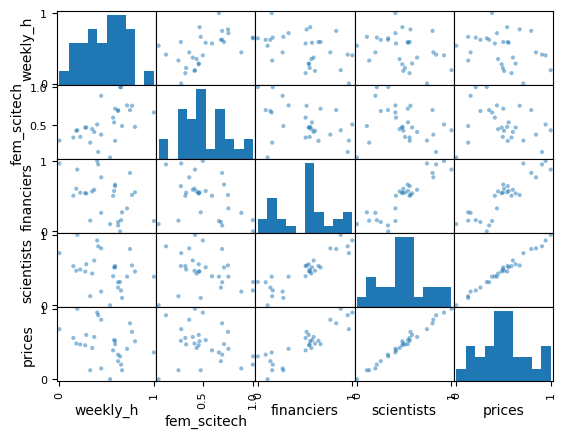

In [26]:
pd.plotting.scatter_matrix(
merged_stats_lognorm.drop(columns=['east_west_g7'])
)

In [27]:
stats.linregress(merged_stats_lognorm['fem_scitech'],y=merged_stats['weekly_h'])

LinregressResult(slope=0.5195813497557528, intercept=0.2166020608571118, rvalue=0.525279875558356, pvalue=0.0034335929653707643, stderr=0.16198488829582536, intercept_stderr=0.09213076082652073)

In [28]:
financiers_vs_prices_lreg=stats.linregress(merged_stats_lognorm['prices'],y=merged_stats_lognorm['financiers'])

In [29]:
financiers_vs_prices_lreg

LinregressResult(slope=0.9916743879209694, intercept=-0.0004183672805469496, rvalue=0.8819328550633375, pvalue=2.5912874269495065e-10, stderr=0.1020042543930971, intercept_stderr=0.057079860735735496)

In [30]:
# Use the Shapiro-Wilks test
shapiro_stat, p_value = stats.shapiro(merged_stats_lognorm['financiers'])

In [31]:
print(shapiro_stat, p_value )

0.9441208655217936 0.1285637213988935


In [32]:
# Use the Shapiro-Wilks test
shapiro_stat_prices, p_value_prices = stats.shapiro(merged_stats_lognorm['prices'])

In [33]:
print(shapiro_stat_prices, p_value_prices )

0.9807683107820879 0.8571583337765442


In [34]:
scientists_vs_prices_lreg=stats.linregress(merged_stats_lognorm['prices'],y=merged_stats_lognorm['scientists'])

In [35]:
scientists_vs_prices_lreg

LinregressResult(slope=0.9572225497796614, intercept=0.012757972756700764, rvalue=0.9917120623870679, pvalue=1.331027714710362e-25, stderr=0.023866127511794274, intercept_stderr=0.013355082518663177)